In [237]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from tqdm import tqdm
import scipy
import pandas as pd
import datetime

import lightgbm as lg

from collections import OrderedDict    # For recording the model specification 

import statsmodels.tools.numdiff as numdiff       # For numeric hessian
import scipy.linalg                    # For matrix inversion
from statsmodels.stats.descriptivestats import describe

import pylogit as pl                   # For choice model estimation
from pylogit import nested_logit as nl # For nested logit convenience funcs
from xlogit import MixedLogit, MultinomialLogit
import lightgbm as lgb

from sklearn.preprocessing import binarize

import pickle
import json

In [239]:
df = pd.read_csv("data/data_2022v2.csv", index_col=0)
df["classement"] = df["classement"].replace(['DA', 'NP', '0', 'A ', 'G ', 'D4', 'D3', 'R8', 'D5', 'D2', 'D8', 'D7', 'H8', 'D1', 'D6',
       'D9', 'G4', 'T ', 'G3', 'D ', 'G7'], 10).astype(int)
df.head()

C:\Users\raves\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (123,125,126) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,nom,numPmu,age,sexe,race,statut,oeilleres,proprietaire,entraineur,deferre,...,medianPerf,modePerf,recordAbs,gain,placeCorde,ecurie,avisEntraineur,tauxReclamation,commentaireApresCourse_texte,commentaireApresCourse_source
0,IROCKO STRYCK,1,4,HONGRES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,Ecurie LES TILLEULS,P. TERRY,DEFERRE_POSTERIEURS,...,3.0,0,0.527465,24490,NaN,NaN,NaN,NaN,NaN,NaN
1,I AM EAGLE,2,4,HONGRES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,Ecurie TENACIOUS SAUVIGNEY,F. MARTY,DEFERRE_POSTERIEURS,...,4.0,4,0.316479,28940,NaN,NaN,NaN,NaN,NaN,NaN
2,IT'S VERY GOOD,3,4,HONGRES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,Mathieu VERDEZ,B. COURBOT,NaN,...,6.0,0,-0.105493,29980,NaN,NaN,NaN,NaN,NaN,NaN
3,IDEAL DE MOUTIERS,4,4,HONGRES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,L.B. MARTIN,L.B. MARTIN,DEFERRE_POSTERIEURS,...,4.0,2,1.265916,30440,NaN,NaN,NaN,NaN,NaN,NaN
4,IRRATI DUEM,5,4,HONGRES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,Ecurie DUEM,J. CHAVATTE,NaN,...,1.5,0,0.105493,31470,NaN,NaN,NaN,NaN,NaN,NaN


In [422]:
sorted(list(df))

['acceleration_500m',
 'age',
 'allure',
 'avisEntraineur',
 'avisTrainer',
 'changementCategorie',
 'classement',
 'commentaireApresCourse_source',
 'commentaireApresCourse_texte',
 'date',
 'deferre',
 'dernierRapportDirect_dateRapport',
 'dernierRapportDirect_favoris',
 'dernierRapportDirect_grossePrise',
 'dernierRapportDirect_indicateurTendance',
 'dernierRapportDirect_nombreIndicateurTendance',
 'dernierRapportDirect_numPmu1',
 'dernierRapportDirect_permutation',
 'dernierRapportDirect_rapport',
 'dernierRapportDirect_typePari',
 'dernierRapportDirect_typeRapport',
 'dernierRapportReference_dateRapport',
 'dernierRapportReference_favoris',
 'dernierRapportReference_grossePrise',
 'dernierRapportReference_indicateurTendance',
 'dernierRapportReference_nombreIndicateurTendance',
 'dernierRapportReference_numPmu1',
 'dernierRapportReference_permutation',
 'dernierRapportReference_rapport',
 'dernierRapportReference_typePari',
 'dernierRapportReference_typeRapport',
 'dist',
 'distTo

In [436]:
feat = df.loc[:]

feat["lifepercwin"] = feat["nombreVictoires"] / feat["nombreCourses"]
feat["winPrace"] = feat["gainsParticipant_gainsCarriere"] / feat["nombreCourses"]
feat["newDist"] = abs(feat["last_race_dist"] - feat["dist"]) > 150

feat["publicProbaOfWinning"] = 1 / feat["dernierRapportDirect_rapport"]
feat["gainDifAnnePrec"] = feat["gainsParticipant_gainsAnneeEnCours"] / feat["gainsParticipant_gainsAnneePrecedente"]

feat.fillna(0,inplace=True)

feat.replace([np.inf, -np.inf], 0, inplace=True)

feat["bonne_reussite_hippo"] = binarize(feat["txReussiteHippo"].to_numpy().reshape(-1, 1),threshold=0.5)
feat["bonne_reussite_couple"] = binarize(feat["txReussiteCouple"].to_numpy().reshape(-1, 1),threshold=0.5)

feat["less_dist_than_last_race"] = (feat["last_race_dist"] > feat["dist"]).astype(int)

feat["place_last_race"] = ((feat["lastPerf"] <= 3) & (feat["lastPerf"] >= 1)).astype(int)

feat["remontada"] = binarize(feat["gain_classement_fin"].to_numpy().reshape(-1, 1),threshold=0.25)

feat["lessThanPreferedDist"] = binarize(feat["prefered_dist"].to_numpy().reshape(-1, 1),threshold=0)

feat["lastTimeToRecord"] = np.exp(feat["tpsLastRace"] - feat["recordAbs"])

feat["win"] = feat["classement"] == 1

feat["available"] = 1

feat["classement"] = feat["classement"].replace(0,10)
feat["win"] = feat["win"].replace(False,0)
feat["win"] = feat["win"].replace(True,1)


feat["newDist"] = feat["newDist"].astype(int)

feat.replace([np.inf, -np.inf], np.nan, inplace=True)

feat = feat.set_index(["id", df.groupby("id").cumcount()])
index = pd.MultiIndex.from_product(feat.index.levels, names=feat.index.names)
feat = feat.reindex(index, fill_value=0).reset_index(level=1, drop=True).reset_index()

nindex = len(df.groupby("id")) * list(range(1,feat.groupby("id").cumcount().max()+2))

feat = feat.assign(num=nindex)

feat = feat.groupby("id").filter(lambda x: x.win.sum() == 1)
feat["chid"] = feat["id"].astype(str) + "_1"

feat["classement"].replace(0, 10, inplace=True)

In [437]:
feat["lastTimeToRecord"].describe()

count    28224.000000
mean         2.551020
std         10.448420
min          0.000000
25%          0.000000
50%          0.454977
75%          1.500381
max        309.389278
Name: lastTimeToRecord, dtype: float64

In [438]:
multiindex = [[],[]]

for i in feat.id.unique():
    for j in range(1,22):
        multiindex[0].append(i)
        multiindex[1].append(j)

In [439]:
# feat = feat.set_index(["id", df.groupby("id").cumcount()])
# test_index = pd.MultiIndex.from_arrays(multiindex, names=["id", "num"])
# feat = feat.reindex(test_index, fill_value=0).reset_index(level=1, drop=True).reset_index()

# nindex = len(df.groupby("id")) * list(range(1,feat.groupby("id").cumcount().max()+2))

# feat = feat.assign(num=nindex)
# feat[["id", "num","nom"]].head(25)

In [440]:
n_explo = 2

nfeat = feat.iloc[:18*(len(feat.groupby("id"))//2)].copy()

train = nfeat.copy()
print(len(train.groupby("chid")))
for i in range(2,n_explo+2):
    cfeat = nfeat.copy()

    cfeat["win"] = 0
    cfeat.loc[cfeat["classement"].isin( list(range(1,i)) ), ~cfeat.columns.isin(["id","num","classement"])] = 0
    cfeat.loc[cfeat["classement"].isin( list(range(1,i)) ),"classement"] = 10
    cfeat.loc[cfeat["classement"] == i, "win"] = 1
    cfeat["classement"] = cfeat["classement"] - 1
    cfeat.loc[cfeat["nom"] == 0, "classement"] = 10
    cfeat["chid"] = cfeat["id"].astype(str) + f"_{i}"
    
    train = pd.concat([train, cfeat])
    print(len(train.groupby("chid")))
train = train.sort_values(by=["id", "chid", "num"])

784
1568
2352


In [441]:
n_course = len(nfeat.groupby("id"))

# train = nfeat.loc[:].iloc[:18 * ( 2 * len(nfeat.groupby("chid"))//3)]
train = train.groupby("chid").filter(lambda x: x.win.sum() == 1)
test = feat.loc[:].iloc[18 * (len(feat.groupby("id")) // 2):]

In [313]:
set(list(feat)) - set(features)

{'allure',
 'available',
 'avisEntraineur',
 'avisTrainer',
 'chid',
 'classement',
 'commentaireApresCourse_source',
 'commentaireApresCourse_texte',
 'date',
 'deferre',
 'dernierRapportDirect_dateRapport',
 'dernierRapportDirect_favoris',
 'dernierRapportDirect_grossePrise',
 'dernierRapportDirect_indicateurTendance',
 'dernierRapportDirect_nombreIndicateurTendance',
 'dernierRapportDirect_numPmu1',
 'dernierRapportDirect_permutation',
 'dernierRapportDirect_rapport',
 'dernierRapportDirect_typePari',
 'dernierRapportDirect_typeRapport',
 'dernierRapportReference_dateRapport',
 'dernierRapportReference_favoris',
 'dernierRapportReference_grossePrise',
 'dernierRapportReference_indicateurTendance',
 'dernierRapportReference_nombreIndicateurTendance',
 'dernierRapportReference_numPmu1',
 'dernierRapportReference_permutation',
 'dernierRapportReference_rapport',
 'dernierRapportReference_typePari',
 'dernierRapportReference_typeRapport',
 'driver',
 'driverChange',
 'ecurie',
 'eleveur

In [205]:
# model = pickle.load(open('models/model_rapport.pickle', 'rb'))

In [19]:
model = MultinomialLogit()
# model = pickle.load(open('models/cl_v1.pickle', 'rb'))

In [442]:
features = ['lastTimeToRecord','lessThanPreferedDist','remontada','place_last_race','less_dist_than_last_race','bonne_reussite_couple',
 'bonne_reussite_hippo','acceleration_500m','nbVictoiresCouple','nbCourseCouple','rentree','last_race_dist','tpsLastRace','timeSinceRecord',
 'minReduction','medianReduction','meanReduction','changementCategorie','distToPreferedDist','prefered_dist','jockeyHabitude',
 'nbDiscalifieMusic','nbVictoireMusic','nbPlaceMusic',
 'fer','gainsParticipant_gainsCarriere','sex','age','dist', 'firstTimeFer',
 'formePlace','formeVictoire','lastPerf','mean_dist_arrivee','nbVictoiresHippo','nombreCourses','nbCourseHippo',
 'txVictoireCouple','txVictoireHippo']

features_bac = ["fer","maxReduction_z","num","meanReduction_z","medianPerf_z","medianReduction_z","nbVictoiresTrainer_z","modePerf_z","nb2emeTandem_z","nb2emeCouple_z","newDist","timeBehindBestInRace_z","timeBehindBestMeanInRace_z","recordAbs_z","nbDiscalifieMusic_z","nbVictoireMusic","nbPlaceMusic","nombrePlacesSecond","nombrePlacesTroisieme_z","gainsParticipant_gainsAnneePrecedente_z","gainsParticipant_gainsVictoires_z","txReussiteTandem_z","lifepercwin","gainsParticipant_gainsAnneeEnCours_z", "txReussiteCouple_z", "nbCourseCouple_z","nbVictoiresCouple_z", "txReussiteTrainer_z", "timeSinceRecord_z", "nombreVictoires_z"]
# features = ["fer","nbDiscalifieMusic","timeBehindBestInRace_z","timeBehindBestMeanInRace_z","nombrePlacesSecond","nombrePlacesTroisieme_z", "txReussiteCouple_z", "nbCourseCouple_z","nbVictoiresCouple_z", "txReussiteTrainer_z", "timeSinceRecord_z", "nombreVictoires_z"]


# randvars = {name:"n" for name in features}
randvars={"nbDiscalifieMusic":"u"}

In [24]:
test.groupby("id")["win"].sum().min()

1

In [494]:
ranker = lg.LGBMRanker(boosting_type="dart",n_estimators=2000,num_leaves=40, metric="ndcg")
groups = train.groupby('chid').size().to_frame('size')['size'].to_numpy()
groups_test = test.groupby('chid').size().to_frame('size')['size'].to_numpy()

ranker.fit(train[features], y=train["classement"],eval_set=[(test[features], test["classement"])],
           eval_group=[groups_test],eval_metric="ndcg", group=groups,verbose=100)

C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's ndcg@1: 0.996369	valid_0's ndcg@2: 0.995448	valid_0's ndcg@3: 0.989048	valid_0's ndcg@4: 0.978687	valid_0's ndcg@5: 0.963355
[200]	valid_0's ndcg@1: 0.998803	valid_0's ndcg@2: 0.996886	valid_0's ndcg@3: 0.990107	valid_0's ndcg@4: 0.980245	valid_0's ndcg@5: 0.963755
[300]	valid_0's ndcg@1: 0.998803	valid_0's ndcg@2: 0.997561	valid_0's ndcg@3: 0.989964	valid_0's ndcg@4: 0.980006	valid_0's ndcg@5: 0.965514
[400]	valid_0's ndcg@1: 0.996299	valid_0's ndcg@2: 0.995086	valid_0's ndcg@3: 0.989064	valid_0's ndcg@4: 0.979368	valid_0's ndcg@5: 0.964167
[500]	valid_0's ndcg@1: 0.998733	valid_0's ndcg@2: 0.996377	valid_0's ndcg@3: 0.98882	valid_0's ndcg@4: 0.978747	valid_0's ndcg@5: 0.964036
[600]	valid_0's ndcg@1: 0.996299	valid_0's ndcg@2: 0.995833	valid_0's ndcg@3: 0.989327	valid_0's ndcg@4: 0.979314	valid_0's ndcg@5: 0.964629
[700]	valid_0's ndcg@1: 0.996299	valid_0's ndcg@2: 0.99534	valid_0's ndcg@3: 0.989813	valid_0's ndcg@4: 0.98033	valid_0's ndcg@5: 0.964573
[800]	valid_0's 

LGBMRanker(boosting_type='dart', early_stopping_round=1, metric='ndcg',
           n_estimators=2000, num_leaves=40)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

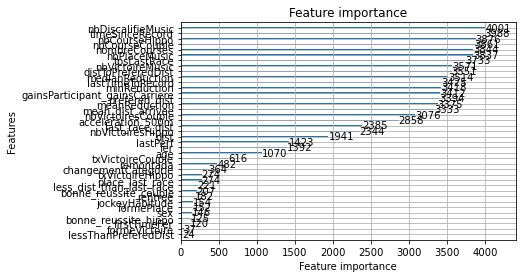

In [491]:
lg.plot_importance(ranker)

In [108]:
# pickle.dump(second_model, open("models/cl_v2.pickle", "wb"))

In [495]:
train_rank_pred = ranker.predict(train[features])
train["rank_pred"] = train_rank_pred

rank_pred = ranker.predict(test[features])
test["rank_pred"] = rank_pred
test['rank_pred'] = test.groupby("chid")["rank_pred"].rank("dense",ascending=True).astype(int)
test['rank_pred'] = test.groupby("chid")["rank_pred"].rank("first").astype(int)

In [496]:
sum(test[test["win"] == 1]["rank_pred"] == 1) / len(test[test["win"] == 1])

0.20535714285714285

In [15]:
model.fit(X = train[features], y = train["win"], varnames=features, ids=train["chid"],alts=train["num"],avail=train["available"],maxiter=10000,tol_opts={"gtol": 1e-10})
model.summary()

Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 7
    Function evaluations: 8
Estimation time= 1.9 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
acceleration_500m       0.0059790     0.0019083     3.1332025       0.00594 ** 
nbVictoiresCouple       0.0373539     0.0355221     1.0515663         0.459    
nbCourseCouple         -0.0303312     0.0347381    -0.8731380         0.545    
rentree                -0.2067202     0.0866816    -2.3848207        0.0465 *  
last_race_dist         -0.0000297     0.0000853    -0.3485531         0.751    
tpsLastRace            -0.1282765     0.0355648    -3.6068373       0.00121 ** 
timeSinceRecord        -0.0624042     0.0243444    -2.5633937          0.03 *  
minReduction           -0.0974908     0.0292492    -3.

In [16]:
choice_estimate, proba_estimate = model.predict(X=train[features], varnames=features, ids=train["chid"], alts=train["num"],avail=train["available"],return_proba=True)
train["probaModel"] = proba_estimate.flatten()
train["probaModel"].replace(-np.inf,0, inplace=True)
train["probaModel"].fillna(0, inplace=True)

In [499]:
null_model = MultinomialLogit()
null_model.fit(X=train[["publicProbaOfWinning"]], y=train["win"], varnames=["publicProbaOfWinning"], ids=train["chid"],alts=train["num"],avail=train["available"])
null_model.summary()
# null_choice, null_proba = null_model.predict(X=test[["publicProbaOfWinning"]], varnames=["publicProbaOfWinning"], ids=test["id"], alts=test["num"], return_proba=True)

# accu = np.sum(winners == null_choice)/len(null_choice)
# print(f"Win%: {round(accu, 4) * 100}%, nbet: {len(choice)}")

Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 5
    Function evaluations: 6
Estimation time= 0.0 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
publicProbaOfWinnin     5.7413131     0.1627448    35.2780093     1.05e-217 ***
---------------------------------------------------------------------------
Significance:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log-Likelihood= -5202.404
AIC= 10406.808
BIC= 10412.568


In [500]:
second_model = MultinomialLogit()
# second_model = pickle.load(open('models/cl_v2.pickle', 'rb'))
second_model.fit(X=train[["publicProbaOfWinning","rank_pred"]],y=train["win"],varnames=["publicProbaOfWinning","rank_pred"], ids=train["chid"],alts=train["num"],avail=train["available"])
second_model.summary()

Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 11
    Function evaluations: 12
Estimation time= 0.0 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
publicProbaOfWinnin     3.1640251     0.2033227    15.5615939      6.87e-51 ***
rank_pred              -1.2218217     0.0335624   -36.4045183     4.85e-229 ***
---------------------------------------------------------------------------
Significance:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log-Likelihood= -3563.881
AIC= 7131.763
BIC= 7143.283


In [455]:
pickle.dump(ranker, open("models/rankerv1.pickle", "wb"))

In [501]:
# choice_model, proba_model = model.predict(X=test[features], varnames=features, ids=test["id"], alts=test["num"],avail=test["available"],return_proba=True)
# test["probaModel"] = proba_model.flatten()
# test["probaModel"].replace(-np.inf,0, inplace=True)
# test["probaModel"].fillna(0, inplace=True)

rank_pred = ranker.predict(test[features])
test["rank_pred"] = rank_pred
# test['rank_pred'] = test.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
# test['rank_pred'] = test.groupby("id")["rank_pred"].rank("first").astype(int)

In [502]:
choice, proba = second_model.predict(X=test[["publicProbaOfWinning","rank_pred"]],varnames=["publicProbaOfWinning","rank_pred"], ids=test["id"],alts=test["num"],avail=test["available"], return_proba=True)

In [503]:
winners_odd = test.loc[test["win"] == 1]["dernierRapportDirect_rapport"].to_numpy()
winners = test.loc[test["win"] == 1]["num"].to_numpy()

odds = test["dernierRapportDirect_rapport"].to_numpy().reshape(-1,18)

def kelly(p,b):
    return p - (1-p)/(b-1)

def expe(p,b):
    e = p*(b+1)
    m_e = np.argmax( e )
    return m_e, e[m_e]

In [504]:
test["proba"] = proba.flatten()

In [505]:
nb_chevaux = []
proba_moy_theo = []
proba_moy = []
rapport_moyen = []
classe = [0,0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.4,1.]
inter = []
prob_real = []
for i,j in zip(classe, classe[1:]):
    inter.append(f"{i} à {j}")
    echantillon = proba.flatten()[(i < proba.flatten()) & (proba.flatten() <= j)]
    
    prob_r = len(test[(i < test["proba"] ) & (test["proba"] <=j ) & (test["win"] == 1)]) / len(test[(i < test["proba"] ) & (test["proba"] <=j )])
    prob_real.append(prob_r)
    
    rapport = test[(i < test["proba"] ) & (test["proba"] <=j )]["dernierRapportDirect_rapport"].to_numpy()
    rapport_moyen.append(np.mean(rapport))
    nb_chevaux.append( len(echantillon ))
    proba_moy.append( np.mean(echantillon) )
    proba_moy_theo.append(np.mean([i,j]))
rapport_moy_theo = 1/np.array(proba_moy_theo)

In [506]:
pd.DataFrame({"PROBA": inter, "Proba moyenne théorique": proba_moy_theo, "Rapport théorique": rapport_moy_theo, "Proba moyenne": proba_moy,"Proba Reelle":prob_real,"Rapport moyen": rapport_moyen, "NB Chevaux": nb_chevaux})

,PROBA,Proba moyenne théorique,Rapport théorique,Proba moyenne,Proba Reelle,Rapport moyen,NB Chevaux
0,0 à 0.01,0.0050,200.000000,0.004847,0.019284,59.511478,2178
1,0.01 à 0.025,0.0175,57.142857,0.016887,0.044081,40.909559,2019
2,0.025 à 0.05,0.0375,26.666667,0.035820,0.065483,28.163707,1802
3,0.05 à 0.1,0.0750,13.333333,0.071677,0.087008,20.087184,1701
4,0.1 à 0.15,0.1250,8.000000,0.121648,0.102288,13.988156,743
5,0.15 à 0.2,0.1750,5.714286,0.172817,0.131455,12.979577,426
6,0.2 à 0.25,0.2250,4.444444,0.222713,0.162602,9.707724,246
7,0.25 à 0.3,0.2750,3.636364,0.273648,0.228571,7.545143,175
8,0.3 à 0.4,0.3500,2.857143,0.342263,0.223684,6.489474,228
9,0.4 à 1.0,0.7000,1.428571,0.593055,0.353276,4.111681,351


In [507]:
accu = np.sum(winners == choice)/len(choice)
print(f"Win%: {round(accu, 4) * 100}%, nbet: {len(choice)}")

Win%: 26.279999999999998%, nbet: 784


In [368]:
with open("data/rapport.json", "r") as f:
    rapports = json.load(f)

In [182]:
test.loc[test["id"] == won_id[0]][["id", "num","numCoursePMU", "classement","date","dernierRapportDirect_rapport"]]

,id,num,numCoursePMU,classement,date,dernierRapportDirect_rapport
26352,2022111275003,1,R1C3,2,2022-11-12,7.3
26353,2022111275003,2,R1C3,3,2022-11-12,6.2
26354,2022111275003,3,R1C3,10,2022-11-12,124.0
26355,2022111275003,4,R1C3,5,2022-11-12,20.0
26356,2022111275003,5,R1C3,10,2022-11-12,9.6
26357,2022111275003,6,R1C3,6,2022-11-12,37.0
26358,2022111275003,7,R1C3,10,2022-11-12,31.0
26359,2022111275003,8,R1C3,4,2022-11-12,34.0
26360,2022111275003,9,R1C3,7,2022-11-12,19.0
26361,2022111275003,10,R1C3,10,2022-11-12,78.0


        mean    max  min  median
0  15.522917  228.1  2.4    6.75
0.09073724007561437% de win
216€ 529 paris


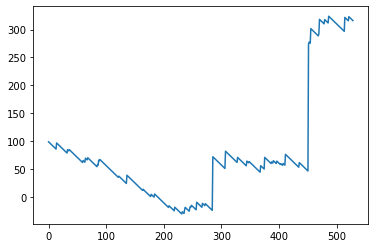

In [530]:
place = []
courses_list = test["id"].unique()

rapport_won = []
evo = []
money = 100
wins = 0

pub_prob = test["publicProbaOfWinning"].to_numpy().reshape(-1,18)

won_id = []

for i in range(len(choice)):
    choice_in_df = test[(test["id"] == courses_list[i]) & (test["num"] == choice[i])].iloc[0]
    sorted_proba = np.argsort(proba[i])
    
    
    proba_jumele = proba[i, sorted_proba[-1]] * (proba[i, sorted_proba[-2]]**(0.76))/ np.sum(np.delete(proba[i],sorted_proba[-1])**(0.76))
#     proba_jumele += proba[i, sorted_proba[-2]] * (proba[i, sorted_proba[-1]]**(0.76))/ np.sum(np.delete(proba[i],sorted_proba[-2])**(0.76))
# #     proba_jumele += proba[i, sorted_proba[-2]] * (proba[i, sorted_proba[-1]]**(0.76))*(proba[i, sorted_proba[-3]]**(0.76)) / np.sum(proba[i]**(0.76))
# #     print(proba_jumele)
    
    proba_public = pub_prob[i, sorted_proba[-1]] * (pub_prob[i, sorted_proba[-2]]**(0.76))/ np.sum(np.delete(pub_prob[i],sorted_proba[-1])**(0.76))
#     proba_public += odds[i, sorted_proba[-2]] * (odds[i, sorted_proba[-1]]**(0.76))/ np.sum(np.delete(odds[i],sorted_proba[-2])**(0.76))
    
    bet_size = 1
    if str(choice_in_df.id) in rapports:
        if "E_COUPLE_GAGNANT" in rapports[str(choice_in_df.id)] and proba_jumele > 1.1*proba_public:
            odd = rapports[str(choice_in_df.id)]["E_COUPLE_GAGNANT"]["rapports"]
            for j in odd:
#                 if (j["dividendePourUnEuro"] / 100 ) * proba[i, sorted_proba[-1]] > 1 :
                if all([x in [sorted_proba[-1] + 1,sorted_proba[-2] + 1] for x in j["combinaison"]]):
#                     print((j["dividendePourUnEuro"] / 100), j["combinaison"],proba_jumele,proba_public)

                    money += bet_size * j["dividendePourUnEuro"] / 100
                    rapport_won.append(j["dividendePourUnEuro"] / 100)
                    won_id.append(courses_list[i])
                    wins+=1
                    break

            money-=1
            evo.append(money)
#                     break

rapport_won = np.array(rapport_won)
print(describe(rapport_won, stats=["max", "min", "mean", "median"]).T)
print(f"{wins/len(evo)}% de win")
print(f"{int(money-100)}€ {len(evo)} paris")
evo = np.array(evo)
plt.plot(evo)

In [142]:
rapports["2022070444188"]

{'E_SIMPLE_GAGNANT': {'typePari': 'E_SIMPLE_GAGNANT',
  'miseBase': 100,
  'rembourse': False,
  'rapports': [{'libelle': 'e-Simple Gagnant',
    'dividende': 190,
    'dividendePourUnEuro': 190,
    'combinaison': [13],
    'nombreGagnants': 9265.43,
    'dividendePourUneMiseDeBase': 190,
    'dividendeUnite': 'PourUnEuro'}],
  'audience': 'NATIONAL',
  'dividendeUnite': 'PourUnEuro',
  'famillePari': 'Simple'},
 'E_SIMPLE_PLACE': {'typePari': 'E_SIMPLE_PLACE',
  'miseBase': 100,
  'rembourse': False,
  'rapports': [{'libelle': 'e-Simple Placé',
    'dividende': 140,
    'dividendePourUnEuro': 140,
    'combinaison': [13],
    'nombreGagnants': 6705.63,
    'dividendePourUneMiseDeBase': 140,
    'dividendeUnite': 'PourUnEuro'},
   {'libelle': 'e-Simple Placé',
    'dividende': 270,
    'dividendePourUnEuro': 270,
    'combinaison': [8],
    'nombreGagnants': 1679.0,
    'dividendePourUneMiseDeBase': 270,
    'dividendeUnite': 'PourUnEuro'},
   {'libelle': 'e-Simple Placé',
    'divide

In [529]:
rapport_won

array([ 11.9,   6.9,   3.1,   4.6,   8.1,   4.8,   3.1,  15.7,   5. ,
         6.6,   3.9,   7.4,   4.8,   7.3,   5.7,   4. ,  14.5,   7.9,
         4.6,  97. ,  31.9,   9.9,   9.4,  12.6,  21.9,   3.8,   5.3,
        20.3,   9.2, 228.1,   4.8,  27.1,  26.4,   8.6,  13. ,  25.9,
         8.3])

In [185]:
test.loc[test["id"] == race_id[-1]][["id", "num","numCoursePMU", "classement","date","dernierRapportDirect_rapport"]]

,id,num,numCoursePMU,classement,date,dernierRapportDirect_rapport
27846,2022112175003,1,R1C3,10,2022-11-21,20.0
27847,2022112175003,2,R1C3,10,2022-11-21,96.0
27848,2022112175003,3,R1C3,3,2022-11-21,7.1
27849,2022112175003,4,R1C3,4,2022-11-21,10.0
27850,2022112175003,5,R1C3,8,2022-11-21,24.0
27851,2022112175003,6,R1C3,7,2022-11-21,7.7
27852,2022112175003,7,R1C3,1,2022-11-21,7.7
27853,2022112175003,8,R1C3,10,2022-11-21,54.0
27854,2022112175003,9,R1C3,2,2022-11-21,14.0
27855,2022112175003,10,R1C3,10,2022-11-21,97.0


In [203]:
def recsum(x):
    return sum([i for i in range(x+1)])

       mean   max  min  median
0  4.973016  13.0  2.0     4.1
Win%: 0.2079207920792079, nwin: 63,nbet: 303, ncourses: 784
Gain de 461€, gain moyen de 0.74%


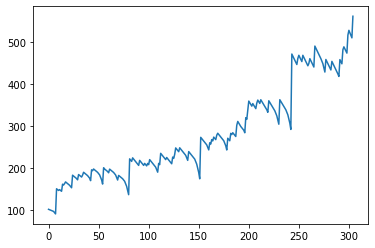

In [525]:
win = 0
tot = 0
odds_winned = []
expe_won = []

money = 100
evo = [101,money]

lstreak = 0

max_lstreak = 0

sorted_proba = np.argsort(proba)

race_id = []

bet = []

gain = []

for i in range(len(choice)):
    cheval,Er = expe(proba[i], odds[i])
#     place_best = sorted_proba[i, -3:]
    
#     best_place,Er = expe(proba[i], odds[i])
#     print(best_place,Er, place_best[best_place])
#     best_expe = place_best[best_place]
    
    er = proba[i, :] * odds[i, :]
    
    er_sorted = np.argsort(er)
    best_espe = er_sorted[-1] + 1 
    

    
    choice_expe = proba[i, choice[i] - 1] * odds[i][choice[i] - 1]
    schoice_expe = proba[i, sorted_proba[-2]] * odds[i][sorted_proba[-2]]
    
#     b_espe = sorted_proba[-1] if choice_expe > schoice_expe else sorted_proba[-2]
#     max_espe = max(choice_expe,schoice_expe)
    
    if choice_expe > 1.7 and odds[i][choice[i] - 1] < 15:
#         wagger1 = kelly(proba[i][choice[i] - 1],odds[i][ choice[i] - 1]) / 3
#         wagger2 = kelly(proba[i][sorted_proba[-2]],odds[i][sorted_proba[-2]]) / 3
#         bet_value = min(wagger*money/3, 0.05*money)
        b1 = max(np.ceil(0.01*money),recsum(int(lstreak/2)))

        if choice[i] == winners[i]:
            race_id.append( test["id"].unique()[i] )
            win += 1
#             print(f"Win le {winners[i]}|{choice[i]} a gagné  avec une cote de {odds[i][winners[i] - 1]}")
            money += odds[i][ winners[i] - 1] * b1
            gain+=[(odds[i][ winners[i] - 1] * b1)/money]
            odds_winned.append(odds[i][winners[i] - 1])
            expe_won.append(choice_expe)
            lstreak = 0
        else:
            gain+=[-b1/money]
            lstreak+=1
            
        money -= b1
        
        max_lstreak = max(max_lstreak, lstreak)
        
        bet.append(b1)
        evo.append(money)
        tot+=1
        
print(describe(odds_winned, stats=["max", "min", "mean", "median"]).T)
# print(describe(expe_won, stats=["max", "min", "mean", "median"]).T)
print(f"Win%: {win/tot}, nwin: {win},nbet: {tot}, ncourses: {len(choice)}")
print(f"Gain de {int(money-100)}€, gain moyen de {round(np.mean(gain)*100,2)}%")
plt.plot(evo)
# plt.yscale("log")

In [526]:
max_lstreak

11

In [527]:
min(evo)

90.0

In [119]:
test[["num", "nom","numCoursePMU", "dernierRapportDirect_rapport"]]

,num,nom,numCoursePMU,dernierRapportDirect_rapport
115561,2,GLORIA D'AVE,R11C2,18.0
115562,3,GOODMORNING CHARLY,R11C2,5.5
115563,4,GATINKA,R11C2,25.0
115564,5,GALIA SOTHO,R11C2,3.3
115565,6,GROVE CITY,R11C2,13.0
...,...,...,...,...
130446,12,HARLEY GEMA,R1C9,3.8
130447,13,HAUTE COUTURE,R1C9,13.0
130448,14,HORCHATA,R1C9,8.6
130449,15,HELIA DU GARABIN,R1C9,8.2


# PyLogit

In [57]:
# Create the model's specification dictionary and variable names dictionary
# NOTE: - Keys should be variables within the long format dataframe.
#         The sole exception to this is the "intercept" key.
#       - For the specification dictionary, the values should be lists
#         or lists of lists. Within a list, or within the inner-most
#         list should be the alternative ID's of the alternative whose
#         utility specification the explanatory variable is entering.




# features_bu = ["available","trainerIsDriver","txReussiteDriver_z","fer","nbArrivé_z","nb3emeTandem_z","nb3emeDriver_z","nb3emeCouple_z","nb2emeTandem_z","nb2emeCouple_z","newDist","timeBehindBestInRace_z","timeBehindBestMeanInRace_z","recordAbs","nbDiscalifieMusic","nbVictoireMusic","nbPlaceMusic","nombrePlacesSecond","nombrePlacesTroisieme_z","gainsParticipant_gainsAnneePrecedente_z","gainsParticipant_gainsVictoires_z","txReussiteTandem_z","winPrace","lifepercwin","gainsParticipant_gainsAnneeEnCours_z", "txReussiteCouple_z", "nbCourseCouple_z","nbVictoiresCouple_z", "txReussiteTrainer_z", "timeSinceRecord_z", "nombreVictoires_z"]
# features = ["fer","nb2emeTandem_z","nb2emeCouple_z","newDist","timeBehindBestInRace_z","timeBehindBestMeanInRace_z","recordAbs","nbDiscalifieMusic","nbVictoireMusic","nbPlaceMusic","nombrePlacesSecond","nombrePlacesTroisieme_z","gainsParticipant_gainsAnneePrecedente_z","gainsParticipant_gainsVictoires_z","txReussiteTandem_z","lifepercwin","gainsParticipant_gainsAnneeEnCours_z", "txReussiteCouple_z", "nbCourseCouple_z","nbVictoiresCouple_z", "txReussiteTrainer_z", "timeSinceRecord_z", "nombreVictoires_z"]

example_specification = OrderedDict()
example_names = OrderedDict()

for col in features:
    example_specification[col] = [list(range(1,19))]
    example_names[col] = [col]

In [58]:
train[features].apply(pd.to_numeric)

,num,dist,lifepercwin,winPrace,formeVictoire,formePlace,nbArriveMusic,lastPerf,meanPerf,medianPerf,...,changementCategorie,distToPreferedDist,prefered_dist,jockeyHabitude,nbDiscalifieMusic,nbVictoireMusic,nbPlaceMusic,fer,firstTimeFer,gainsParticipant_gainsCarriere
0,1,2700,0.409091,4.504293,0,0,-1.6,-0.727273,-1.196854,-0.666667,...,0,-0.854795,0.723898,1,2.000000,-1.0,-0.8,3,0,-4.003816
1,2,2700,0.409091,1.604153,1,1,-0.6,0.545455,-0.341958,-0.333333,...,0,2.432877,-2.060325,1,-1.333333,2.0,0.0,1,1,-1.425914
2,3,2700,0.000000,0.000000,0,1,0.0,0.000000,0.132984,0.000000,...,0,0.000000,0.000000,0,0.666667,-1.0,0.4,3,0,-0.589825
3,4,2700,0.461538,0.743243,0,0,-1.0,-0.727273,0.940386,1.000000,...,0,2.410959,-2.041763,0,0.000000,-1.0,-0.8,3,0,-0.585586
4,5,2700,0.000000,-0.735404,0,0,-0.4,0.909091,0.390810,0.666667,...,0,0.252055,-0.213457,0,2.000000,-1.0,0.0,3,0,-0.430843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19309,14,2825,0.188889,0.000000,0,0,-1.0,0.516129,1.206024,1.076923,...,1,-0.359932,0.359932,0,-0.250000,-1.0,-1.0,0,0,0.000000
19310,15,0,0.000000,0.000000,0,0,0.0,0.000000,0.000000,0.000000,...,0,0.000000,0.000000,0,0.000000,0.0,0.0,0,0,0.000000
19311,16,0,0.000000,0.000000,0,0,0.0,0.000000,0.000000,0.000000,...,0,0.000000,0.000000,0,0.000000,0.0,0.0,0,0,0.000000
19312,17,0,0.000000,0.000000,0,0,0.0,0.000000,0.000000,0.000000,...,0,0.000000,0.000000,0,0.000000,0.0,0.0,0,0,0.000000


In [59]:
train["chid"].dtypes

dtype('int64')

In [60]:
# The 'alt_id_column' is the name of a column to be created in the long-format data
# It will identify the alternative associated with each row.
alt_id_column = "num"

# The "obs_id_column" is a custom id column that ignores the fact that this is a 
# panel/repeated-observations dataset. This column denotes each individual choice
# situation.
obs_id_column = "chid"

# The "choice_column" records the name of the column that denotes whether or not each
# individual chose the alternative on a given row.
choice_column = "win"

In [78]:
# Provide the module with the needed input arguments to create
# an instance of the MNL model class


example = pl.create_choice_model(data=train,
                                        alt_id_col=alt_id_column,
                                        obs_id_col=obs_id_column,
                                        choice_col=choice_column,
                                        specification=example_specification,
                                        model_type="MNL",
                                        names=example_names)

# Create the initial values for estimation.
# Note that we need one value for each beta
# coefficient and for each of the standard deviations
# that will now be estimated.

example.fit_mle(init_vals=np.zeros(len(features)))
example.get_statsmodels_summary()

Log-likelihood at zero: -9,263.6415
Initial Log-likelihood: -9,263.6415


C:\Users\raves\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:548: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


Estimation Time for Point Estimation: 0.81 seconds.
Final log-likelihood: -7,948.5208


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                         win   No. Observations:                3,205
Model:             Multinomial Logit Model   Df Residuals:                    3,169
Method:                                MLE   Df Model:                           36
Date:                     Thu, 24 Nov 2022   Pseudo R-squ.:                   0.142
Time:                             13:42:32   Pseudo R-bar-squ.:               0.138
AIC:                            15,969.042   Log-Likelihood:             -7,948.521
BIC:                            16,187.650   LL-Null:                    -9,263.641
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
num                               -0.0018      0.005     -0.338      0.735      -0.012       0.009
dist                               0.7106      0.003    238.108      0.000       0.705       0.716
lifepercwin                    -7.531e-05      0.004     -0.021      0.983      -0.007       0.007
winPrace                          4.4e-05      0.003      0.015      0.988      -0.006       0.006
formeVictoire                   8.061e-05      0.087      0.001      0.999      -0.171       0.171
formePlace                         0.0002      0.059      0.004      0.997      -0.115       0.115
nbArriveMusic                      0.0001      0.030      0.004      0.997      -0.058       0.058
lastPerf                        1.249e-05      0.026      0.000      1.000      -0.050       0.050
meanPerf                          -0.0002      0.036     -0.007      0.995      -0.071       0.070
medianPerf                        -0.0002      0.039     -0.006      0.996      -0.077       0.076
modePerf                           0.0001      0.013      0.011      0.991      -0.025       0.025
recordAbs                         -0.0001      0.024     -0.004      0.997      -0.047       0.046
txReussiteCouple                   0.0003      0.021      0.015      0.988      -0.041       0.042
nb3emeCouple                       0.0002      0.018      0.009      0.993      -0.036       0.036
nb2emeCouple                       0.0002      0.019      0.011      0.991      -0.037       0.038
nbVictoiresCouple                  0.0003      0.021      0.015      0.988      -0.040       0.041
nbCourseCouple                  8.486e-05      0.021      0.004      0.997      -0.041       0.041
rentree                         5.163e-06      0.051      0.000      1.000      -0.101       0.101
last_race_dist                     0.7178   7.13e-05   1.01e+04      0.000       0.718       0.718
tpsLastRace                       -0.0002      0.005     -0.032      0.974      -0.011       0.011
timeSinceRecord                 -9.24e-05      0.016     -0.006      0.996      -0.032       0.032
minReduction                      -0.0001      0.014     -0.009      0.993      -0.028       0.028
maxReduction                   -2.972e-05      0.017     -0.002      0.999      -0.034       0.034
medianReduction                   -0.0001      0.022     -0.006      0.995      -0.043       0.043
meanReduction                     -0.0001      0.034     -0.004      0.997      -0.067       0.067
newDist                            0.0001      0.041      0.003      0.997      -0.081       0.081
changementCategorie                0.0002      0.041      0.004      0.997      -0.081       0.081
distToPreferedDist              1.308e-06      0.021   6.27e-05      1.000      -0.041       0.041
prefered_dist                   4.412e-05      0.022      0.002      0.998      -0.043       0.043
jockeyHabitude              

In [75]:
preds = example.predict(test).reshape(-1,18)
preds_course = np.argmax(preds, axis=1) + 1
acu = sum(test.loc[test["win"] == 1]["num"] == preds_course) / len(preds_course)
print(acu)

0.0625


In [77]:
preds[0]

array([1.00000000e-001, 1.00000000e-001, 1.00000000e-001, 1.00000000e-001,
       1.00000000e-001, 1.00000000e-001, 1.00000000e-001, 1.00000000e-001,
       1.00000000e-001, 1.00000000e-001, 9.66331526e-306, 9.64565933e-306,
       9.62803566e-306, 9.61044419e-306, 9.59288487e-306, 9.57535762e-306,
       9.55786240e-306, 9.54039915e-306])

In [13]:
winners_odd = test.loc[test["win"] == 1]["dernierRapportDirect_rapport"].to_numpy()

In [71]:
winners_odd = test.loc[test["win"] == 1]["dernierRapportDirect_rapport"].to_numpy()

def kelly(p,b):
    return p - (1-p)/b

def expe(p,b):
    e = p*b - (1-p)
    m_e = np.argmax( p*b - (1-p) )
    return m_e, e[m_e]

In [106]:
winners = test.loc[test["win"] == 1]["num"].to_numpy()
odds = test["dernierRapportDirect_rapport"].to_numpy().reshape(-1,18)

sorted_preds = np.argsort(preds)

best_p = 0
best_er = 0

best_cap = 0



for p_tresh in np.linspace(0,0.2,40):
    for er_tresh in np.linspace(0,1.5,40):
        win = 0
        tot = 0
    #     odds_winned = []

        cap = 100
    #     evo = [cap]


        for i in range(len(preds)):
            preds1 = sorted_preds[i][-1]
            preds2 = sorted_preds[i][-2]
            cheval,Er = expe(preds[i], odds[i])
            if odds[i][cheval] > 0 and Er > er_tresh and preds[i][cheval] > p_tresh:
                wagger = kelly(preds[i][cheval],odds[i][cheval]) * cap
                if winners[i] == cheval + 1:
                    win += 1
                    cap += wagger * odds[i][cheval]
    #                 odds_winned.append(odds[i][cheval])
                cap -= wagger
    #             evo.append(cap)
                tot+=1

        if cap > best_cap:
            best_cap = cap
            best_p = p_tresh
            best_er = er_tresh
print(f"Best cap: {best_cap} for params: {best_p=}, {best_er=}")

Best cap: 460.79357800673836 for params: best_p=0.015384615384615385, best_er=0.9230769230769231


                 0
mean     21.361538
max     173.000000
min       4.400000
median    8.000000
Win%: 0.13829787234042554, nbet: 94


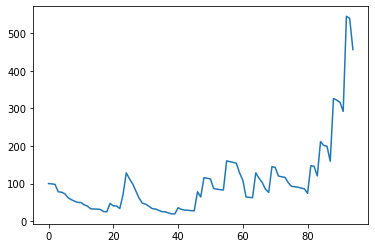

In [108]:
from statsmodels.stats.descriptivestats import describe
win = 0
tot = 0
odds_winned = []

cap = 100
evo = [cap]


winners_odd = test.loc[test["win"] == 1]["dernierRapportDirect_rapport"].to_numpy()

def kelly(p,b):
    return p - (1-p)/b

def expe(p,b):
    e = p*b - (1-p)
    m_e = np.argmax( p*b - (1-p) )
    return m_e, e[m_e]

for i in range(len(preds)):
    preds1 = sorted_preds[i][-1]
    preds2 = sorted_preds[i][-2]
    cheval,Er = expe(preds[i], odds[i])
    if odds[i][cheval] > 0 and Er > 0.92 and preds[i][cheval] > 0.015:
        wagger = kelly(preds[i][cheval],odds[i][cheval]) * cap
        if winners[i] == cheval + 1:
            win += 1
            cap += wagger * odds[i][cheval]
            odds_winned.append(odds[i][cheval])
        cap -= wagger
        evo.append(cap)
        tot+=1
print(describe(odds_winned, stats=["max", "min", "mean", "median"]))
print(f"Win%: {win/tot}, nbet: {tot}")
plt.plot(evo)

In [89]:
mean_odds = np.mean(odds_winned)
median_odds = np.median(odds_winned)
print(mean_odds, median_odds, np.max(odds_winned), np.min(odds_winned))

5.328688524590164 4.8 15.0 1.4


In [99]:
test

,id,num,nom,numCoursePMU,classement,date,meanReduction,medianReduction,maxReduction,minReduction,...,txReussiteTandem_z,nbVictoiresDriver_z,nb2emeDriver_z,nb3emeDriver_z,txReussiteDriver_z,lifepercwin,winPrace,newDist,win,available
15948,2021072250083,1,HIPPO DE BEAUM,R6C3,10,2021-07-22,783.571429,781.0,822,765,...,-1.681135,-0.714631,-0.735320,-0.873203,-2.227441,0.000000,19583.333333,0,0,1
15949,2021072250083,2,HACH DES CAPELLES,R6C3,8,2021-07-22,801.000000,802.0,805,794,...,-0.898975,-0.697110,-0.718105,-0.873203,-0.928100,0.100000,99700.000000,1,0,1
15950,2021072250083,3,HOCHE,R6C3,1,2021-07-22,777.000000,777.5,784,769,...,0.665343,1.475570,1.055025,0.948539,0.725606,0.000000,70000.000000,0,1,1
15951,2021072250083,4,HADOL DU CHATELET,R6C3,10,2021-07-22,783.142857,790.0,795,761,...,1.660819,0.249057,0.504149,1.164271,0.371240,0.066667,48866.666667,1,0,1
15952,2021072250083,5,HAUGAIN,R6C3,6,2021-07-22,781.500000,784.5,798,759,...,-0.970081,-0.714631,-0.735320,-0.801293,-1.046222,0.100000,116700.000000,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31891,2021123175009,14,HORCHATA,R1C9,7,2021-12-31,766.727273,765.0,807,733,...,1.153314,-0.046198,-0.047263,0.186222,-0.025928,0.142857,133761.904762,1,0,1
31892,2021123175009,15,HELIA DU GARABIN,R1C9,8,2021-12-31,769.500000,766.5,805,741,...,-0.314991,-0.847823,-0.962680,-1.116216,-0.440775,0.307692,210000.000000,1,0,1
31893,2021123175009,16,HELEN DES OUBEAUX,R1C9,4,2021-12-31,774.500000,766.5,811,750,...,-0.672146,0.620089,1.040624,0.560896,0.527201,0.000000,50875.000000,1,0,1
31894,2021123175009,17,0,0,10,0,0.000000,0.0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0


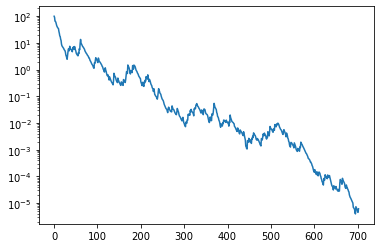

In [90]:
plt.plot(evo)
plt.yscale("log")

In [3]:
import pickle
example_mixed = pickle.load(open("mixedlogit1.pkl", "rb"))

# PyLogit

In [8]:
# NOTE: - Specification and variable names must be ordered dictionaries.
#       - Keys should be variables within the long format dataframe.
#         The sole exception to this is the "intercept" key.
#       - For the specification dictionary, the values should be lists
#         of integers or or lists of lists of integers. Within a list, 
#         or within the inner-most list, the integers should be the 
#         alternative ID's of the alternative whose utility specification 
#         the explanatory variable is entering. Lists of lists denote 
#         alternatives that will share a common coefficient for the variable
#         in question.

basic_specification = OrderedDict()
basic_names = OrderedDict()


for f in features:
    print(f)

basic_specification["intercept"] = [1, 2]
basic_names["intercept"] = ['ASC Train',
                            'ASC Swissmetro']

basic_specification["travel_time_hrs"] = [[1, 2,], 3]
basic_names["travel_time_hrs"] = ['Travel Time, units:hrs (Train and Swissmetro)',
                                  'Travel Time, units:hrs (Car)']

basic_specification["travel_cost_hundreth"] = [1, 2, 3]
basic_names["travel_cost_hundreth"] = ['Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Train)',
                                       'Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Swissmetro)',
                                       'Travel Cost, units: 0.01 CHF (Car)']

basic_specification["headway_hrs"] = [1, 2]
basic_names["headway_hrs"] = ["Headway, units:hrs, (Train)",
                              "Headway, units:hrs, (Swissmetro)"]

basic_specification["seat_configuration"] = [2]
basic_names["seat_configuration"] = ['Airline Seat Configuration, base=No (Swissmetro)']

basic_specification["train_survey"] = [[1, 2]]
basic_names["train_survey"] = ["Surveyed on a Train, base=No, (Train and Swissmetro)"]

basic_specification["regular_class"] = [1]
basic_names["regular_class"] = ["First Class == False, (Swissmetro)"]

basic_specification["single_luggage_piece"] = [3]
basic_names["single_luggage_piece"] = ["Number of Luggage Pieces == 1, (Car)"]

basic_specification["multiple_luggage_pieces"] = [3]
basic_names["multiple_luggage_pieces"] = ["Number of Luggage Pieces > 1, (Car)"]

fer
nb2emeTandem_z
nb2emeCouple_z
newDist
timeBehindBestInRace_z
timeBehindBestMeanInRace_z
recordAbs
nbDiscalifieMusic
nbVictoireMusic
nbPlaceMusic
nombrePlacesSecond
nombrePlacesTroisieme_z
gainsParticipant_gainsAnneePrecedente_z
gainsParticipant_gainsVictoires_z
txReussiteTandem_z
lifepercwin
gainsParticipant_gainsAnneeEnCours_z
txReussiteCouple_z
nbCourseCouple_z
nbVictoiresCouple_z
txReussiteTrainer_z
timeSinceRecord_z
nombreVictoires_z
